<a href="https://colab.research.google.com/github/matheusldettmar/TCC-MATHEUSDETTMAR/blob/main/TCCv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Inicialização


In [1788]:
reset-f

In [1789]:
import numpy as np
import math
from math import e
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import matplotlib.dates as mdates

In [1790]:
data = '20220819'

In [1791]:
endereco = '/content/UFSC_19082022.xlsx'

Upload das tabelas

In [1792]:
basePVT = pd.read_excel(endereco, header = 1)
baseI = pd.read_excel(endereco, sheet_name = 'BSRN')
baseINMET = pd.read_csv('/content/generatedBy_react-csv.csv', sep = ';')

In [1793]:
from datetime import time

start = time(6)
end = time(19)

basePVT = basePVT[basePVT['DATE'].dt.time.between(start, end)]
basePVT = basePVT.reset_index(drop='True')

In [1794]:
basePVT

,DATE,T1,T2,T3,T4,T5,T6,T7,T8,Q1,Q2
0,2022-08-19 06:00:07,13.602069,9.474734,8.779793,7.015450,10.233306,9.567116,6.862011,10.061207,0.0,0.0
1,2022-08-19 06:00:17,13.764138,9.273972,9.450691,7.225405,10.239381,9.802066,7.045230,9.897296,0.0,0.0
2,2022-08-19 06:00:27,13.788092,9.221026,9.178379,7.035619,9.937414,9.719286,7.138105,10.030294,0.0,0.0
3,2022-08-19 06:00:37,13.700764,9.573491,8.766071,7.277743,10.596961,9.883924,6.839801,10.041664,0.0,0.0
4,2022-08-19 06:00:47,13.518838,9.343794,9.456199,7.191025,10.196199,9.573309,6.781505,10.197381,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4675,2022-08-19 18:59:17,19.939756,12.223792,12.299366,10.094722,12.710585,12.080088,10.175981,12.469562,0.0,0.0
4676,2022-08-19 18:59:27,19.920900,12.220874,12.243049,10.027312,12.751806,12.113335,10.242980,12.395094,0.0,0.0
4677,2022-08-19 18:59:37,20.095690,12.194274,12.286056,9.955978,12.708800,12.137522,10.192506,12.408936,0.0,0.0
4678,2022-08-19 18:59:47,20.011052,12.085441,12.370718,10.058049,12.696389,12.114335,10.169099,12.423480,0.0,0.0


#Módulo FVT

## Tratamento das tabelas

T1 – Temperatura do reservatório

T2 – Temperatura de entrada da água no trocador

T3 – Temperatura de saída da água no trocador

T4 – Temperatura do módulo FV

T5 – Temperatura da água que sai da caixa d’água e entra no reservatório

T6 – Temperatura de saída da água para consumo

T7 – Temperatura do módulo FVT

T8 – Temperatura ambiente

Q1 - Vazão FVT (l/min)

Q2 - Vazão consumo (l/min)

**Transformando colunas `DATE` e `TIME` para formato datetime**

In [1795]:
basePVT['DATE'] = pd.to_datetime(basePVT['DATE'], format = '%Y-%m-%d %H:%M:%S')

**Extraindo somente a data e hora de cada coluna**

In [1796]:
basePVT['TIME'] = 0
basePVT['TIME'] = [d.time() for d in basePVT['DATE']]
basePVT['DATE'] = [d.date() for d in basePVT['DATE']]


**Transformando em string e tirando os segundos**

In [1797]:
basePVT['DATE'] = [d.strftime('%Y-%m-%d') for d in basePVT['DATE']]
basePVT['TIME'] = [d.strftime('%H:%M') for d in basePVT['TIME']] 

**Juntando a data e hora na coluna `DATE`**

In [1798]:
basePVT['DATE'] =  basePVT['DATE'] + ' ' + basePVT['TIME']
basePVT['DATE'] = pd.to_datetime(basePVT['DATE'], format = '%Y-%m-%d %H:%M:%S')

**Deletando colunas desnecessárias**

In [1799]:
basePVT = basePVT[['DATE', 'T1', 'T2', 'T3', 'T5', 'T6', 'T7', 'T8', 'Q1', 'Q2']]

**Adicionando `T_amb` e `I` na tabela onde o horario coincide**

In [1800]:
basePVT = pd.merge(basePVT, baseI, left_on = 'DATE', right_on = 'Data' )

In [1801]:
basePVT = basePVT.drop(basePVT[basePVT['I_t'] < 0].index)

In [1802]:
basePVT = basePVT.drop(['T_amb'], axis = 1)

In [1803]:
basePVT = basePVT.reset_index(drop='True')

?????

In [1804]:
basePVT = basePVT.groupby(['DATE']).mean()

**Renomeando as colunas**

In [1805]:
basePVT.rename(columns = {'T1':'Tt', 'T2':'Te_ref', 'T3':'Ts_ref', 'T5':'e_Tt', 'T6':'Ts', 'Q2':'e_Ts', 'T7':'Tt_ref', 'T8':'Tamb'}, inplace = True)

In [1806]:
basePVT = basePVT.reset_index()

**Coluna só com hora para junção com dados do INMET**

In [1807]:
basePVT['HORA'] = [d.strftime('%Y-%m-%d %H') for d in basePVT['DATE']] 

**Descartando dados de quando o trocador ta desligado**

In [1808]:
#basePVT = basePVT.drop(basePVT[basePVT['Q1'] == 0].index)

In [1809]:
basePVT.dropna(subset=['Tamb'])

,DATE,Tt,Te_ref,Ts_ref,e_Tt,Ts,Tt_ref,Tamb,Q1,e_Ts,I_t,HORA
0,2022-08-19 06:00:00,13.676896,9.444600,9.264396,10.229097,9.702233,6.976892,10.006661,0.0,0.000000,0.000000,2022-08-19 06
1,2022-08-19 06:01:00,13.567595,9.394311,9.391524,10.149219,10.395476,7.014311,10.033091,0.0,1.219697,0.000000,2022-08-19 06
2,2022-08-19 06:02:00,12.460582,9.554429,8.864415,10.887364,17.282695,7.209410,10.117264,0.0,8.656566,0.000000,2022-08-19 06
3,2022-08-19 06:03:00,11.841941,9.602144,7.263773,11.313639,18.450816,7.052647,10.127576,0.0,8.712122,0.000000,2022-08-19 06
4,2022-08-19 06:04:00,11.540107,9.403664,6.833872,11.312380,18.637402,6.819958,10.152278,0.0,8.684344,0.000000,2022-08-19 06
...,...,...,...,...,...,...,...,...,...,...,...,...
775,2022-08-19 18:55:00,20.011573,12.297313,12.364334,12.688835,12.164603,10.278586,12.498105,0.0,0.000000,534.380299,2022-08-19 18
776,2022-08-19 18:56:00,19.963348,12.206439,12.366934,12.752227,12.148684,10.256080,12.490116,0.0,0.000000,530.213775,2022-08-19 18
777,2022-08-19 18:57:00,20.011223,12.191424,12.383298,12.677547,12.118304,10.215830,12.465258,0.0,0.000000,525.263921,2022-08-19 18
778,2022-08-19 18:58:00,19.991697,12.203528,12.301547,12.680775,12.116818,10.214393,12.513426,0.0,0.000000,521.657684,2022-08-19 18


## INMET

https://tempo.inmet.gov.br/TabelaEstacoes/A806

**Descartando colunas desnecessárias**

In [1810]:
baseINMET = baseINMET.drop(['Umi. Ins. (%)', 'Umi. Max. (%)', 'Umi. Min. (%)', 'Pressao Ins. (hPa)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)', 'Chuva (mm)'], axis = 1)

**Ajustando Data e Hora**

In [1811]:
baseINMET['t'] = [float(t)/100 for t in baseINMET['Hora (UTC)']]

In [1812]:
baseINMET['Hora (UTC)'] = baseINMET['Hora (UTC)'].astype(str)

In [1813]:
i=0
for h in baseINMET['Hora (UTC)']:
  if len(h) == 1:
    baseINMET.iloc[i,1] = '000' + h
    i += 1
  elif len(h) == 3:
    baseINMET.iloc[i,1] = '0' + h
    i += 1
  else:
    i+=1 

In [1814]:
baseINMET.iloc[:,0] = baseINMET.iloc[:,0] + ' ' + baseINMET.iloc[:,1] 


In [1815]:
i = 0
for d in baseINMET['Data']:
  baseINMET.iloc[i,0] = d[:13]+':'+d[13:]
  i += 1

In [1816]:
baseINMET['Data'] = baseINMET['Data'] + ':00' 

In [1817]:
baseINMET['Data'] = pd.to_datetime(baseINMET['Data'], format = '%d/%m/%Y %H:%M:%S')

In [1818]:
baseINMET['Data'] = [d.strftime('%Y-%m-%d %H') for d in baseINMET['Data']]

**Juntando com a bae principal**

In [1819]:
basePVT = pd.merge(basePVT, baseINMET, left_on = 'HORA', right_on = 'Data' )

**Descartando colunas desnecessárias**

In [1820]:
basePVT = basePVT.drop(['Data'], axis = 1)
basePVT = basePVT.drop(['Hora (UTC)'], axis = 1)
basePVT = basePVT.drop(['HORA'], axis = 1)

In [1821]:
basePVT = basePVT.reset_index()

## Constantes 

In [1822]:
Cf = 4200
nc = 0.18

Constantes radiativas

In [1823]:
tv = 0.81
e_v = 0.85
alpha_v = 0
alpha_c = 0.9
alpha_e = (alpha_c - nc)*tv
sigma = 5.6697*10**(-8) 

Dimensões do Módulo

In [1824]:
w = 1.007 # datasheet
L = 2.067 # datasheet
ec = 0.0032
et = 0.001
epp = 0.0007
ei = 0.02
ev = 0.004 # datasheet

##  Constantes de condutividade e coeficientes de convecção





**Cálculo dos coeficientes de convecção**

In [1825]:
v = basePVT.iloc[:,18]
v = v.replace({',': '.'}, regex=True)
v =[float(V) for V in v]
#v =[3 for V in v]

In [1826]:
h_convv = [2.8 + 3 * V for V in v] #h_conv = 2,8 + 3 * v forçada# 
h_f = 500
h_convi = 5 #h_conv_nat = 1,78 * (T_isolamento - T_amb)# h_conv = (h_conv_for ^3 + h_conv_nat ^3)^(1/3)

Constantes de condução e resistências

In [1827]:
kv = 1.8
kc = 148 
kt = 0.36
kpp =  0.21
ki = 0.035

R_contato = 8

Uvc = kv/ev
Uct = kc/ec
Utf = (et/kt + R_contato + epp/kpp + 1/h_f)**(-1)
Ufai = (1/h_convi + ei/ki + epp/kpp + 1/h_f)**(-1)

## Valores iniciais

**Suavização da curva de `Tamb`**

In [1828]:
media_movel = 3
Te_smooth = np.convolve(basePVT['Tamb'], np.ones(media_movel), mode = 'valid')
Te_smooth /= media_movel

In [1829]:
Te_smooth = pd.DataFrame(Te_smooth)

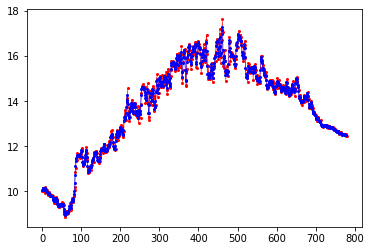

In [1830]:
plt.plot(basePVT['index'], basePVT['Tamb'], 'ro-', linewidth=0.5, markersize=2)
plt.plot(Te_smooth, 'bo-', linewidth=0.5, markersize=2)
plt.show()

In [1831]:
basePVT['Tamb'] = Te_smooth[0]

In [1832]:
Te_smooth.isna().value_counts()

False    778
dtype: int64

**Suavização da curva de `Ia`**

In [1833]:
media_movel = 10
Te_smooth = np.convolve(basePVT['I_t'], np.ones(media_movel), mode = 'valid')
Te_smooth /= media_movel

In [1834]:
Te_smooth = pd.DataFrame(Te_smooth)

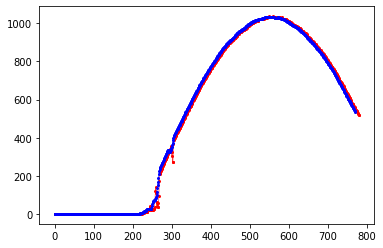

In [1835]:
plt.plot(basePVT['index'], basePVT['I_t'], 'ro-', linewidth=0.5, markersize=2)
plt.plot(Te_smooth, 'bo-', linewidth=0.5, markersize=2)
plt.show()

In [1836]:
basePVT['I_t'] = Te_smooth[0]

**Suavização da curva de `Te`*

In [1837]:
media_movel = 7
Te_smooth = np.convolve(basePVT['Te_ref'], np.ones(media_movel), mode = 'valid')
Te_smooth /= media_movel

In [1838]:
Te_smooth = pd.DataFrame(Te_smooth)

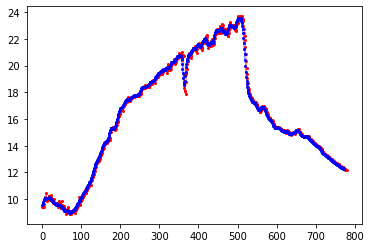

In [1839]:
plt.plot(basePVT['index'], basePVT['Te_ref'], 'ro-', linewidth=0.5, markersize=2)
plt.plot(Te_smooth, 'bo-', linewidth=0.5, markersize=2)
plt.show()

In [1840]:
basePVT = basePVT.reset_index(drop='True')

In [1841]:
basePVT = basePVT.drop(['index'], axis = 1)

In [1842]:
basePVT = basePVT.reset_index()

In [1843]:
basePVT = basePVT.dropna(subset=['Tamb'])

In [1844]:
basePVT['Tamb'].isna().value_counts()

False    778
Name: Tamb, dtype: int64

In [1845]:
Ta = basePVT.iloc[:,8] #+ 273
Tfe = basePVT.iloc[:,2] #+ 273

**Extraindo valores da tabela para os cálculos**

In [1846]:
I = basePVT['I_t']*0.59
T_amb = basePVT['Tamb'] + 273
T_e =  basePVT['Te_ref'] + 273

Tdp = basePVT.iloc[:,15]
Tdp = Tdp.replace({',': '.'}, regex=True)
Tdp =[float(T) for T in Tdp]
#Tdp =[18 for T in Tdp]


t = basePVT['t']

In [1847]:
T_c=[]
T_t = []
T_fs = []
Q_u = []

## Solução da energia térmica útil e eficiência

In [1848]:
mf = (basePVT.iloc[:,9])/3600
for j in range(len(T_amb)):

  Tv = T_amb[j] + 2  # CHUTE INICIAL
  Tceu = (T_amb[j])*(0.711 + 0.0056*Tdp[j] + 0.000073*(Tdp[j]**2) + 0.013*(np.cos(15*t[j])))**(1/4)
  Tt_i = 25
  Tt = 26
  
  while abs(Tt_i - Tt) > 0.00001:
    
    if Tv != T_amb[j] and mf[j] != 0:
 
      Tt_i = Tt

      h_radv = e_v*sigma*(Tv**2 + Tceu**2)*(Tv + Tceu)
      R_radv = (Tv - T_amb[j])/(h_radv*(Tv - Tceu))
      Uva = h_convv[j] + R_radv**(-1)
      Uca = (1/(R_radv**-1 + h_convv[j]) + ev/kv)**-1
      hp1 = Uct/(Uca + Uct)
      Uta = hp1*Uca
      hp2 = Utf/(Utf + Uta)
      Ufav = hp2*Uta
      Ul = Ufai + Ufav


      Tfm = (hp2*hp1*alpha_e*I[j]/Ul + T_amb[j])*(1+(e**(-w*Ul*L/(mf[j]*Cf)) - 1)/(w*Ul*L/(mf[j]*Cf))) - T_e[j]*((e**(-w*Ul*L/(mf[j]*Cf)) - 1)/(w*Ul*L/(mf[j]*Cf)))
      Tfs = (hp2*hp1*alpha_e*I[j]/Ul + T_amb[j])*(1-e**(-w*Ul*L/(mf[j]*Cf))) + T_e[j]*e**(-w*Ul*L/(mf[j]*Cf))
      #Qu = (mf[j]*Cf/Ul)*(hp2*hp1*alpha_e*I[j] + Ul*T_amb[j] - Ul*T_e[j])*(1-e**(w*Ul*L/(mf[j]*Cf)))
      #n = (nc*tv*I[j]*w*L + Qu)/(I[j]*w*L)
      Tt = (hp1*alpha_e*I[j] + Uta*T_amb[j] + Utf*Tfm)/(Utf + Uta)
      Tc = (alpha_e*I[j] + Uca*T_amb[j] +Uct*Tt)/(Uca + Uct)
      Tv = (I[j]*alpha_v + Tc*Uvc + T_amb[j]*Uva)/(Uvc + Uva)
    
    elif Tv != T_amb[j] and mf[j] == 0:

      Tt_i = Tt
      
      h_radv = e_v*sigma*(Tv**2 + Tceu**2)*(Tv + Tceu)
      R_radv = (Tv - T_amb[j])/(h_radv*(Tv - Tceu))
      Uva = h_convv[j] + R_radv**(-1)
      Uca = (1/(R_radv**-1 + h_convv[j]) + ev/kv)**-1
      hp1 = Uct/(Uca + Uct)
      Uta = hp1*Uca
      hp2 = Utf/(Utf + Uta)
      Ufav = hp2*Uta
      Ul = Ufai + Ufav


      Tfm = hp2*hp1*alpha_e*I[j]/Ul + T_amb[j]
      Tfs = hp2*hp1*alpha_e*I[j]/Ul + T_amb[j]
      #Qu = (mf[j]*Cf/Ul)*(hp2*hp1*alpha_e*I[j] + Ul*T_amb[j] - Ul*T_e[j])*(1-e**(w*Ul*L/(mf[j]*Cf)))
      #n = (nc*tv*I[j]*w*L + Qu)/(I[j]*w*L)
      Tt = (hp1*alpha_e*I[j] + Uta*T_amb[j] + Utf*Tfm)/(Utf + Uta)
      Tc = (alpha_e*I[j] + Uca*T_amb[j] +Uct*Tt)/(Uca + Uct)
      Tv = (I[j]*alpha_v + Tc*Uvc + T_amb[j]*Uva)/(Uvc + Uva)

    else:

      Tt_i = Tt
 
  T_t.append(Tt)
  T_c.append(Tc) 
  T_fs.append(Tfs)

 
 
 

In [1849]:
basePVT['Tt'] = T_t
basePVT['Ts'] = T_fs
#basePVT['Qu'] = Q_u

## Gráficos

In [1850]:
#basePVT['DATE'] = [d.time() for d in basePVT['DATE']]

In [1851]:
basePVT['Tt_ref'] = basePVT['Tt_ref']+273

In [1852]:
basePVT['Ts_ref'] = basePVT['Ts_ref']+273

Temperatura de saída do trocador

In [1853]:
import matplotlib.dates as mdates

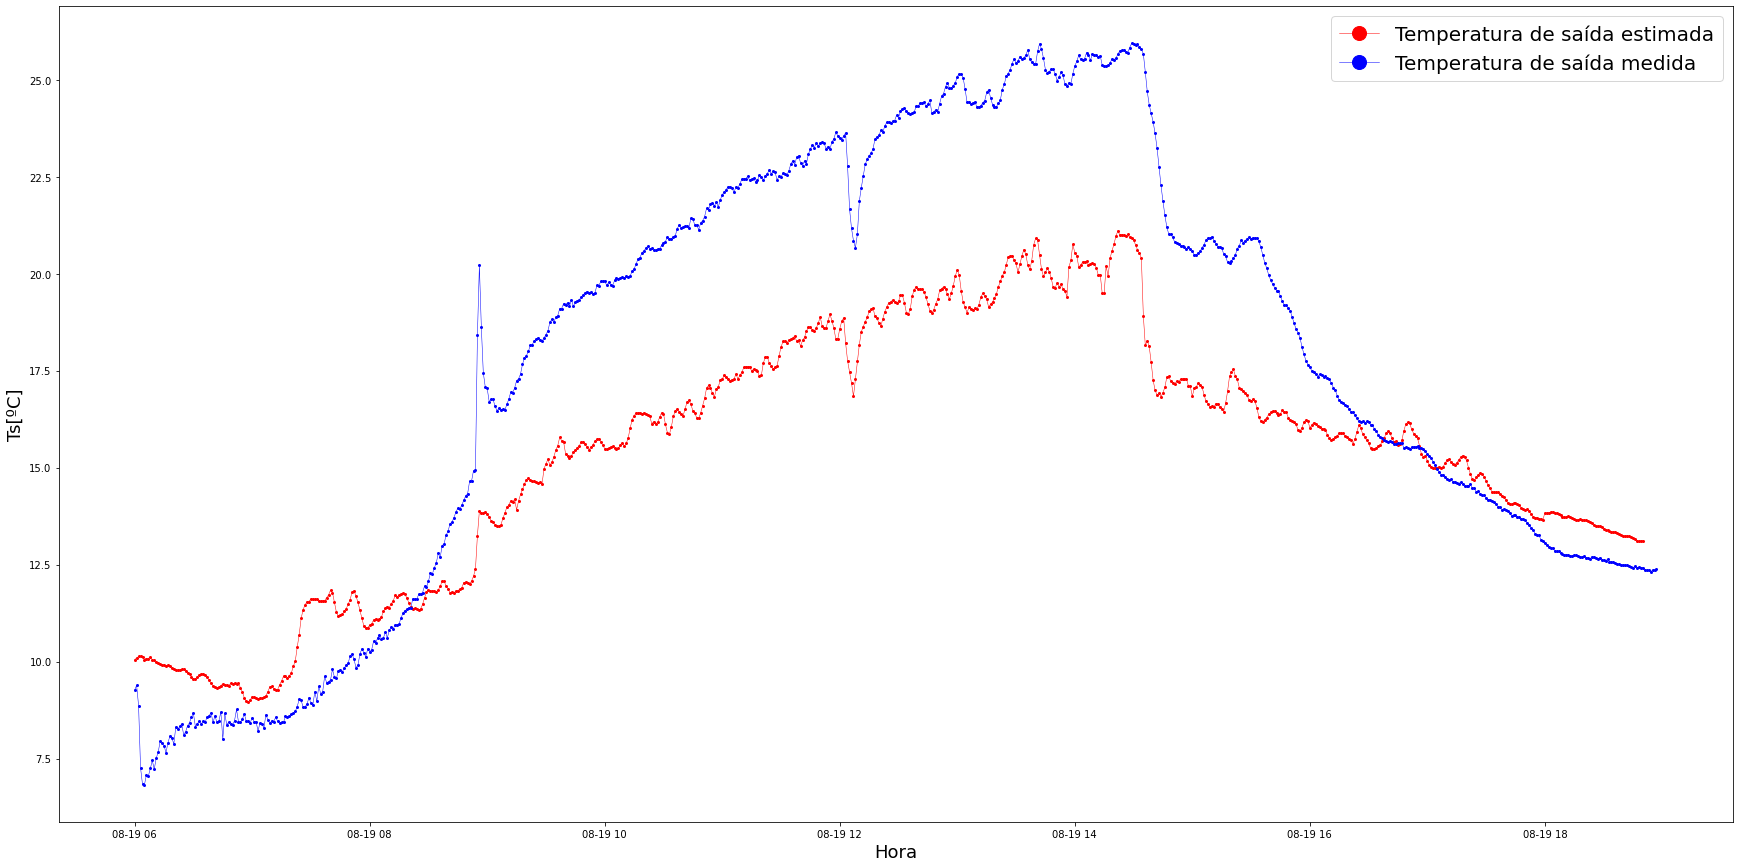

In [1854]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
plt.xlabel('Hora', fontsize = 18)
plt.ylabel('Ts[ºC]', fontsize = 18)
plt.plot(basePVT['DATE'], basePVT['Ts']-273, 'ro-', linewidth=0.5, markersize=2, label='Temperatura de saída estimada')
plt.plot(basePVT['DATE'], basePVT['Ts_ref']-273, 'bo-', linewidth=0.5, markersize=2, label='Temperatura de saída medida')
plt.legend(loc='best', prop = {'size': 20}, markerscale = 7 )
plt.savefig(data + "-Ts.jpg", prop={'size': 20})
plt.show()

Grafico percentual do erro da temperatura de saída do trocador

In [1855]:
basePVT['e_Ts'] = (basePVT['Ts']- basePVT['Ts_ref'])*100/(basePVT['Ts_ref']-273)

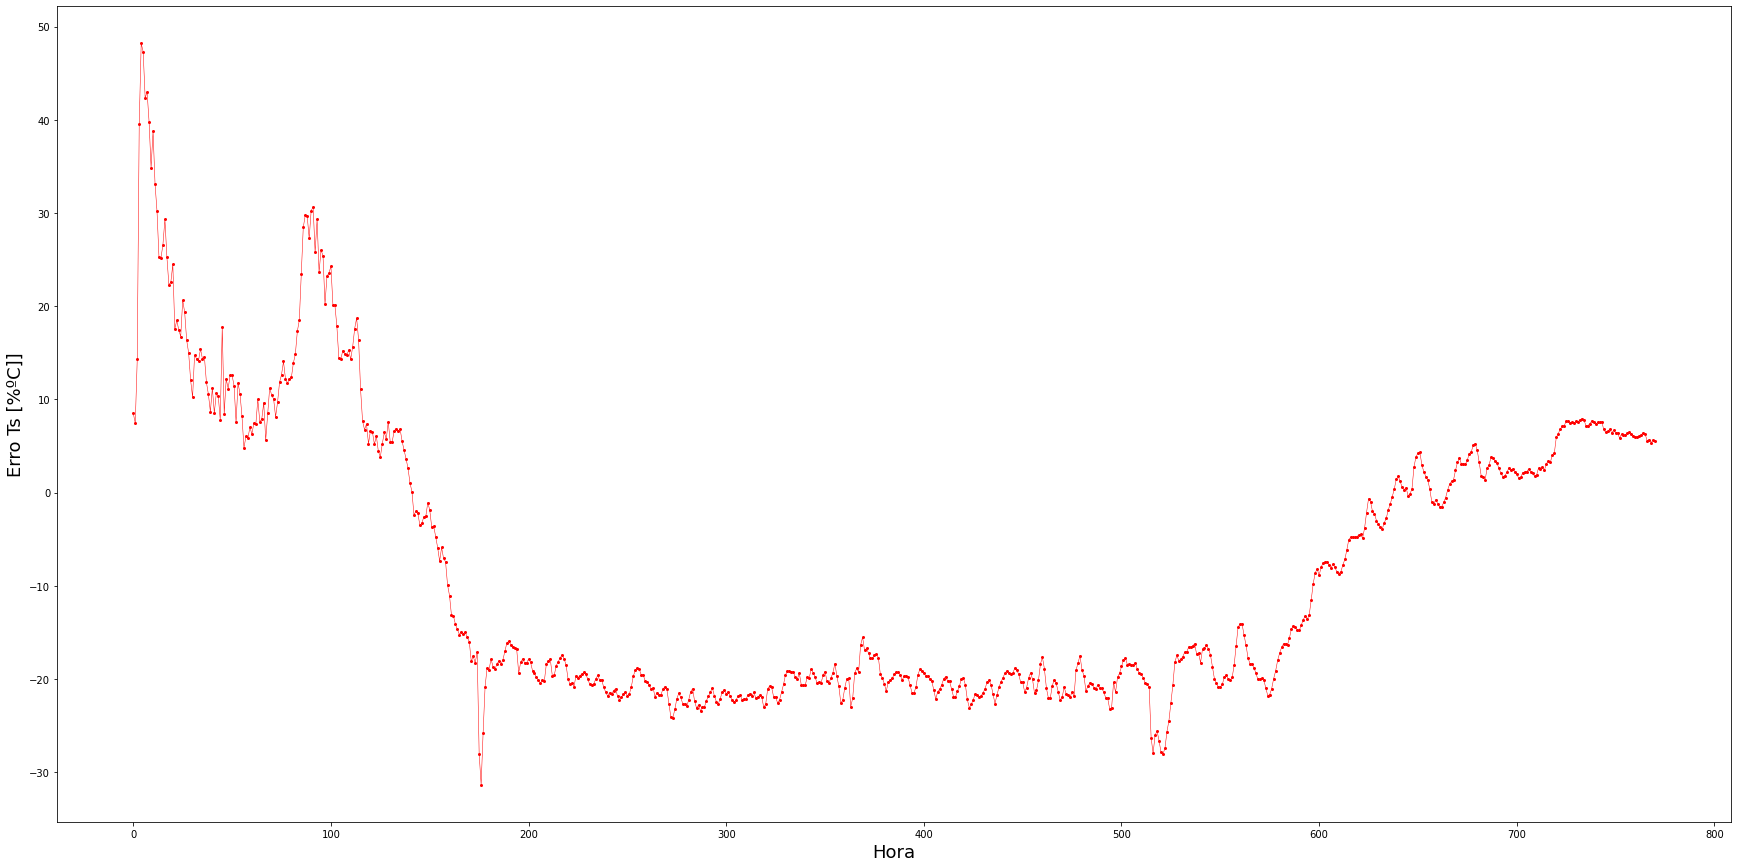

In [1856]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
plt.xlabel('Hora', fontsize = 18)
plt.ylabel('Erro Ts [%ºC]]', fontsize = 18)
plt.plot( basePVT['e_Ts'], 'ro-', linewidth=0.5, markersize=2)
plt.savefig(data + "-e_Ts.jpg")
plt.show()

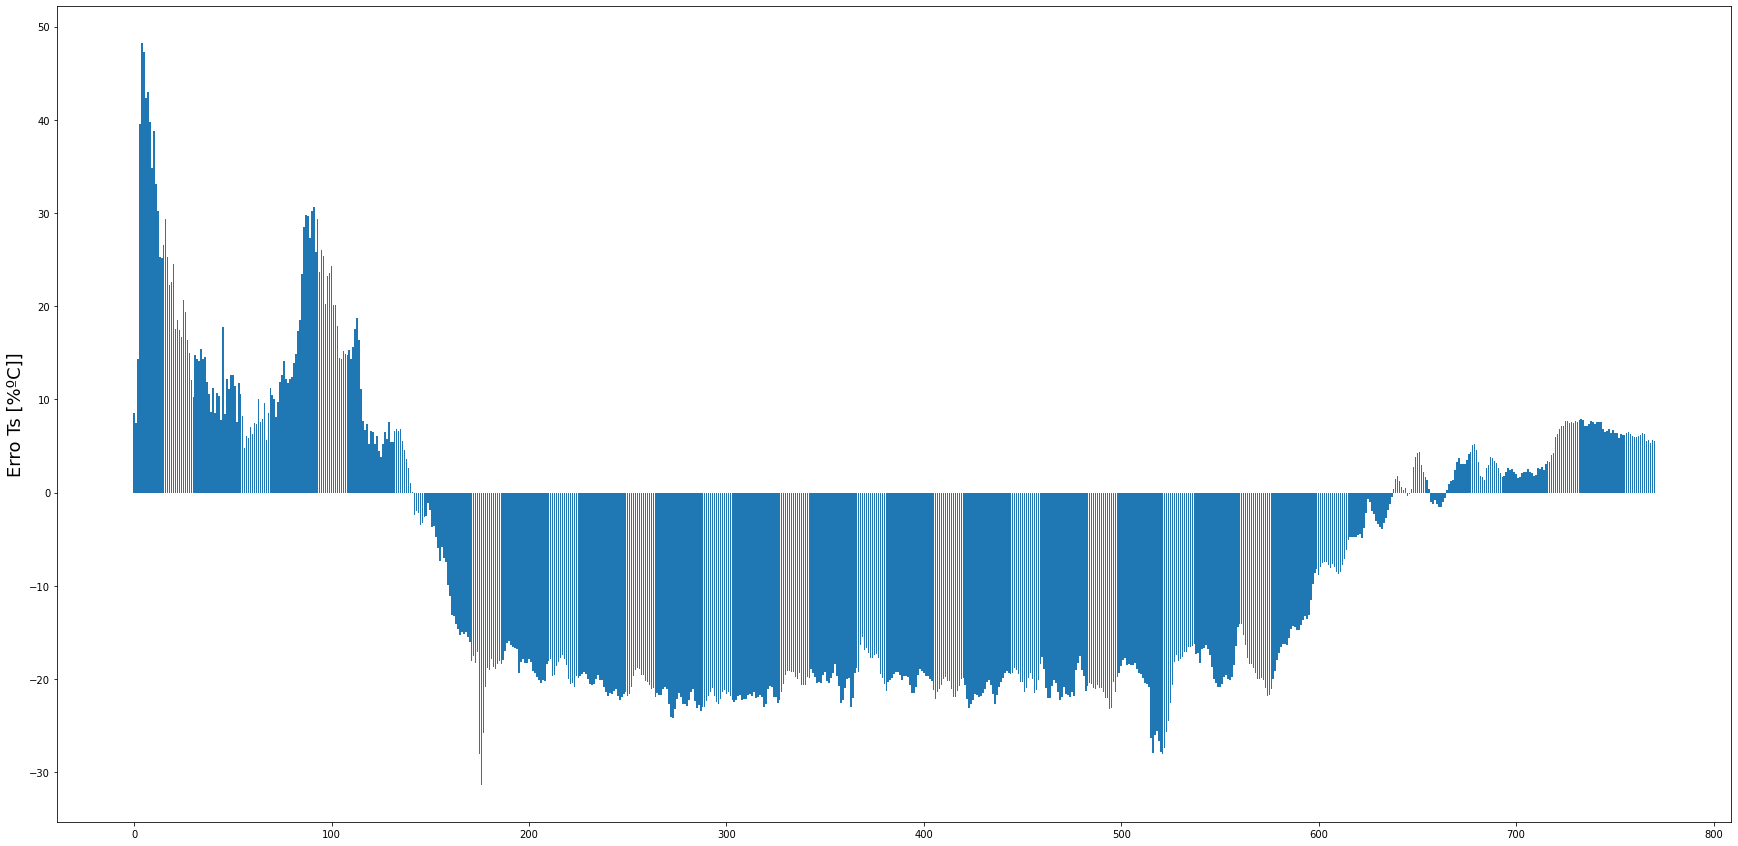

In [1857]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
plt.ylabel('Erro Ts [%ºC]]', fontsize = 18)
plt.bar(basePVT['index'], basePVT['e_Ts'])
plt.savefig(data + "-e_Ts.jpg")

Temperatura do módulo

In [1858]:
T_c = [T - 273 for T in T_c]

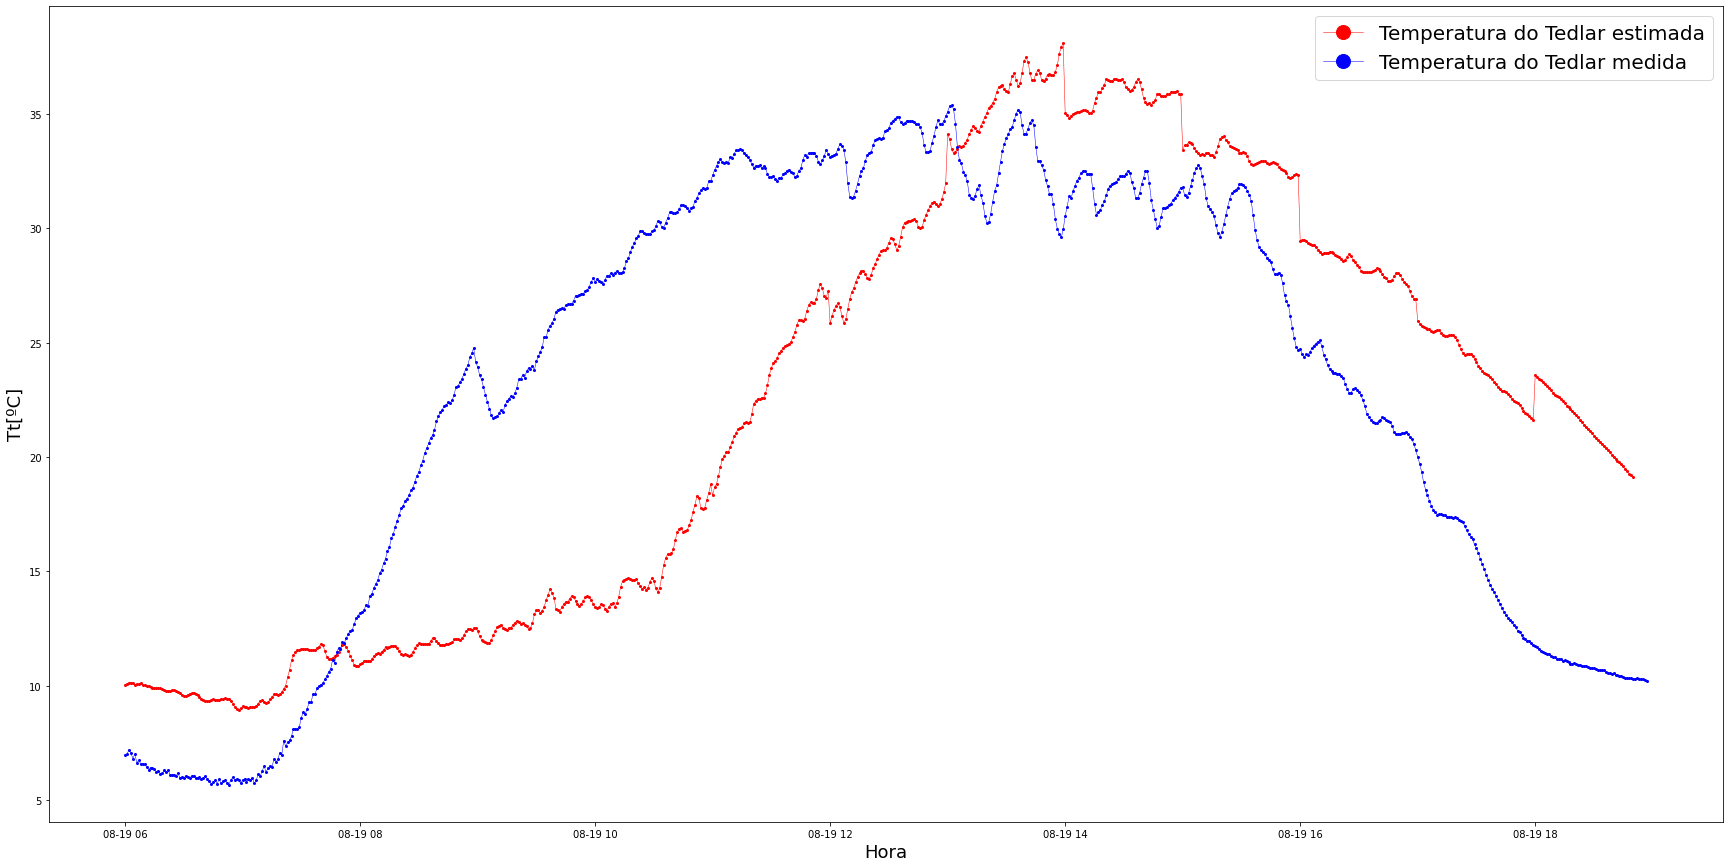

In [1859]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
plt.xlabel('Hora', fontsize = 18)
plt.ylabel('Tt[ºC]', fontsize = 18)
#plt.plot(basePVT['DATE'], T_c, 'go-', linewidth=0.5, markersize=2, label='Temperatura do módulo estimada')
plt.plot(basePVT['DATE'], basePVT['Tt']-273, 'ro-', linewidth=0.5, markersize=2, label='Temperatura do Tedlar estimada')
plt.plot(basePVT['DATE'], basePVT['Tt_ref']-273, 'bo-', linewidth=0.5, markersize=2, label='Temperatura do Tedlar medida')
plt.legend(loc='best', prop = {'size': 20}, markerscale = 7 )
plt.savefig(data + "-Tt.jpg")
plt.show()

Grafico do percentual do erro da temperatura do módulo

In [1860]:
basePVT['e_Tt'] = (basePVT['Tt']- basePVT['Tt_ref'])*100/(basePVT['Tt_ref']-273)

In [1861]:
abs(basePVT['e_Ts']).mean() #8.69222522447186.  6.713847381371213.  24.283666803318763.  24.36272476649011

15.181099471133141

1o 5.771776510669755 2o 19.436400063632323 3o 4.678146436278794

In [1862]:
abs(basePVT['e_Tt']).mean() #24.358991552643328.  19.434838293216753.  24.283666803318763.  24.36272476649011

35.798764099806405

1o 24.287390768120044 2o 19.436400063632323 3o 19.193885890908287

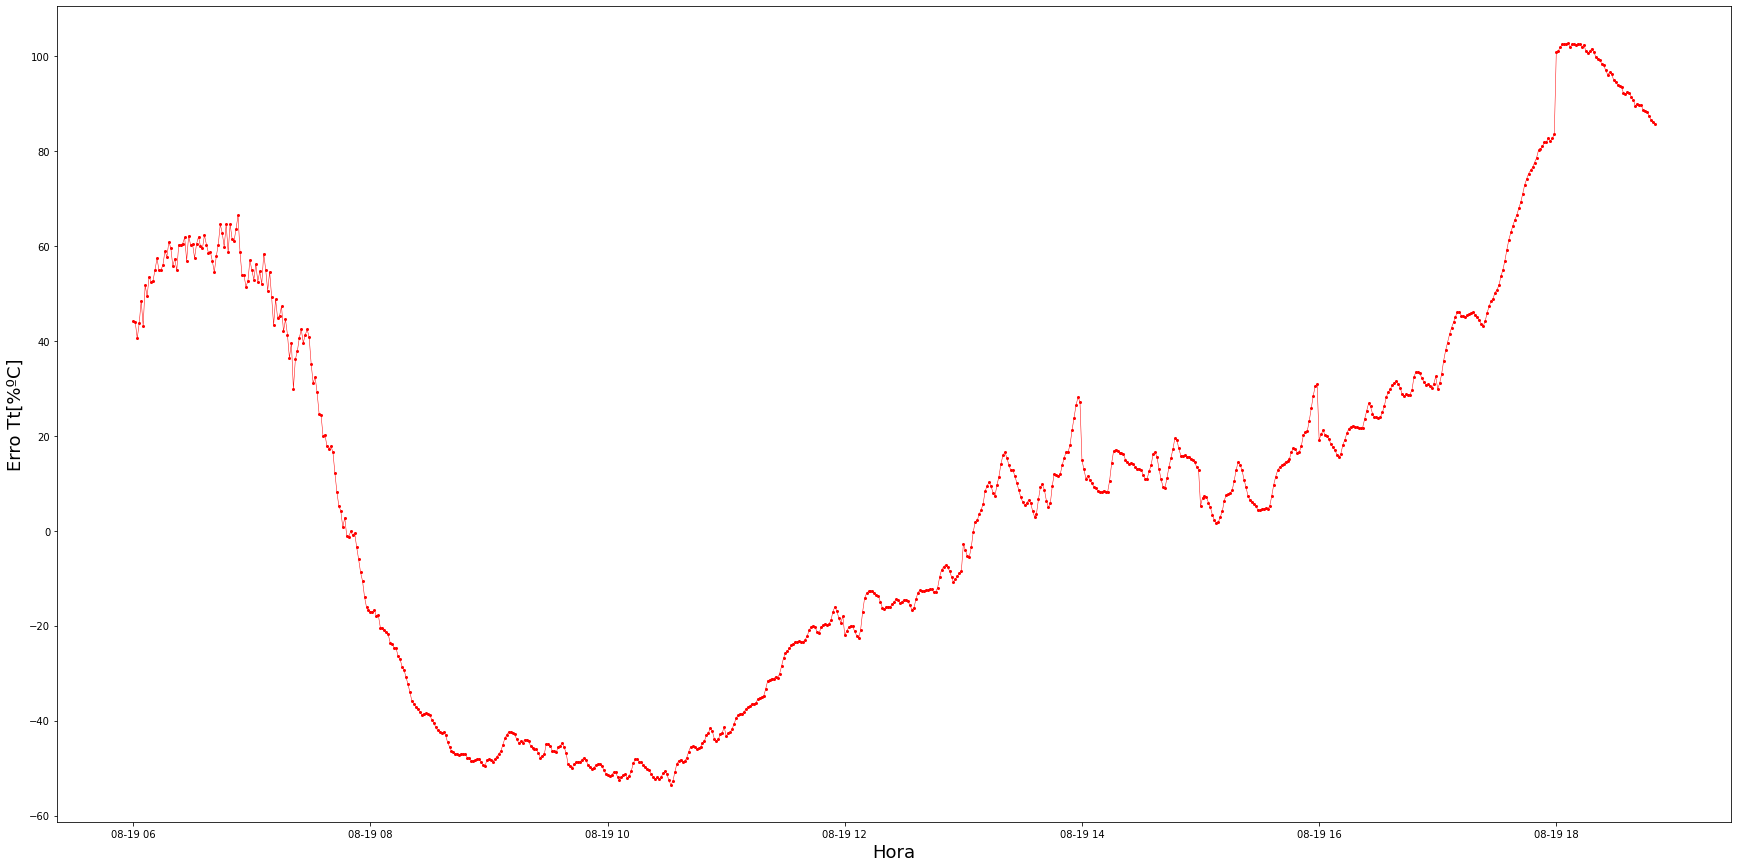

In [1863]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
plt.xlabel('Hora', fontsize = 18)
plt.ylabel('Erro Tt[%ºC]', fontsize = 18)
plt.plot(basePVT['DATE'], basePVT['e_Tt'], 'ro-', linewidth=0.5, markersize=2)
plt.savefig(data + "-e_Tt.jpg")
plt.show()

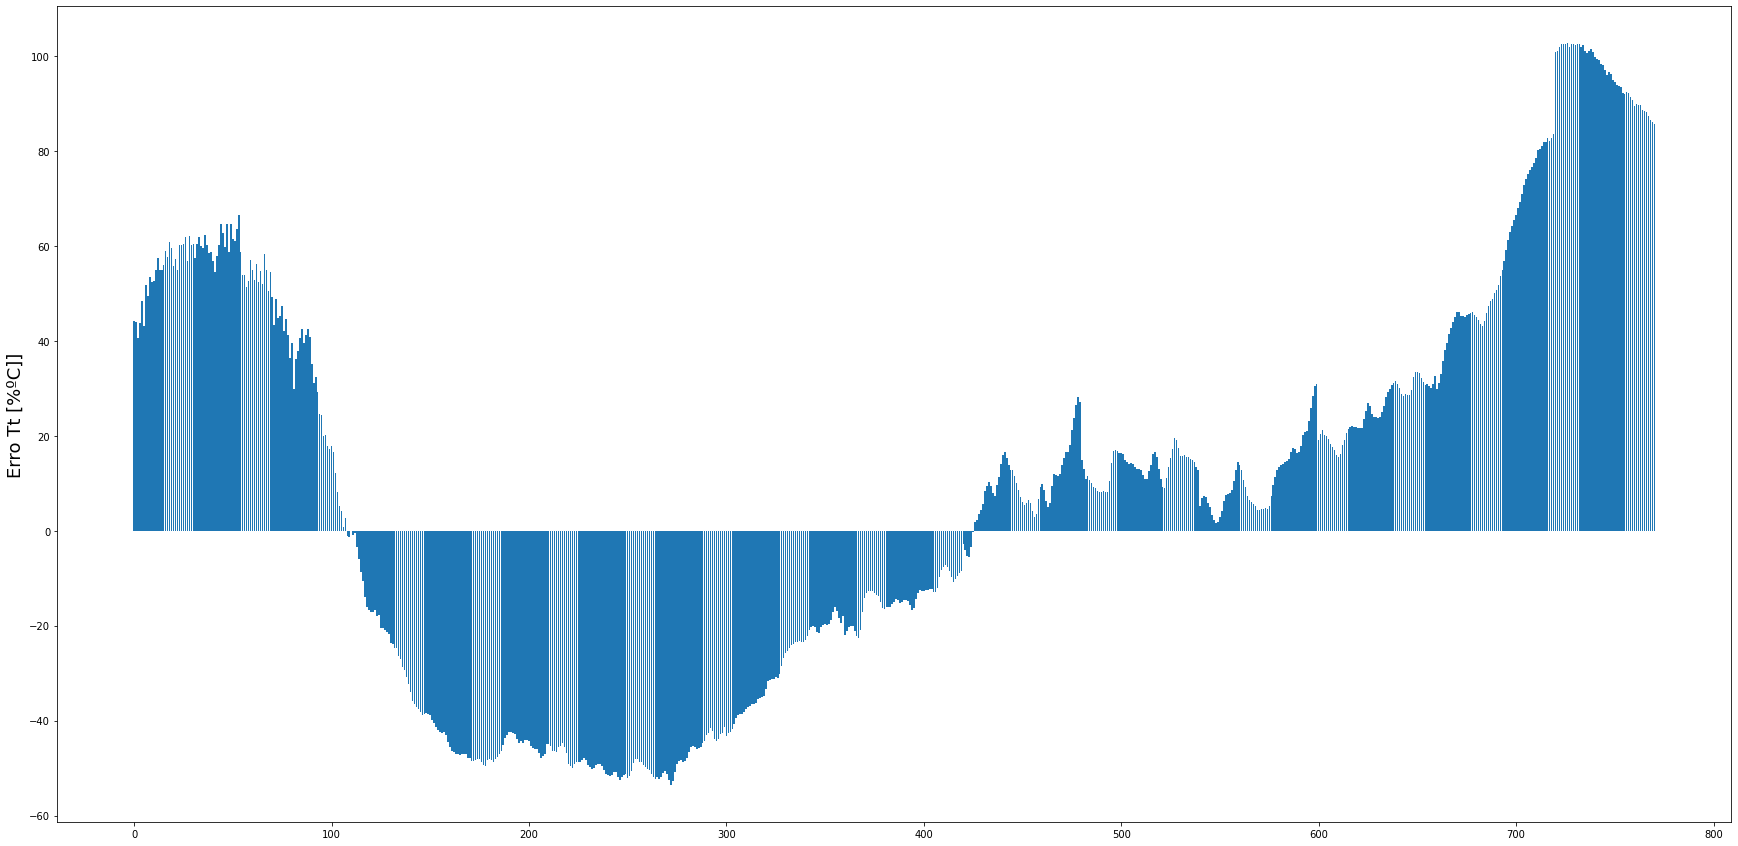

In [1864]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
plt.ylabel('Erro Tt [%ºC]]', fontsize = 18)
plt.bar(basePVT['index'], basePVT['e_Tt'])
plt.savefig(data + "-e_Tt.jpg")

In [1865]:
#basePVT['Tc'].iloc[j,14] = Tc
 #basePVT['Tfs'].iloc[j,15] = Tfs
 #basePVT['Qu'].iloc[j,16] = Qu

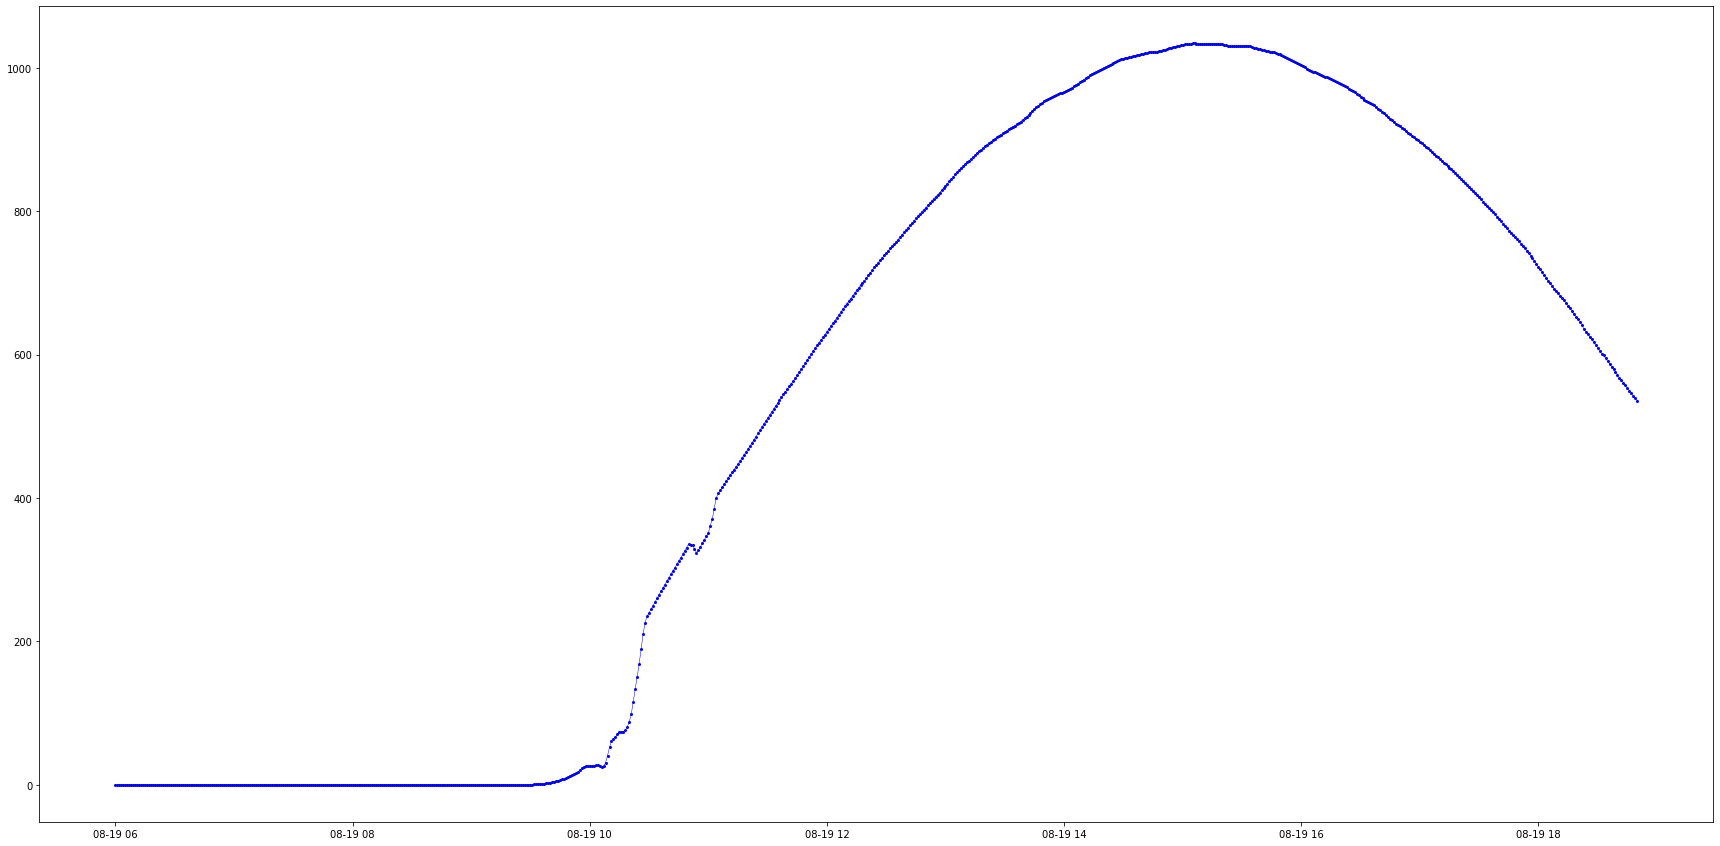

In [1866]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(15)
#plt.plot(basePVT['DATE'], basePVT['Tamb'], 'ro-', linewidth=0.5, markersize=2)
plt.plot(basePVT['DATE'], basePVT['I_t'], 'bo-', linewidth=0.5, markersize=2)
#plt.plot(basePVT['DATE'], basePVT['Te_ref'], 'bo-', linewidth=0.5, markersize=2)
#plt.plot(basePVT['index'], mf, 'go-', linewidth=0.5, markersize=2)


plt.show()

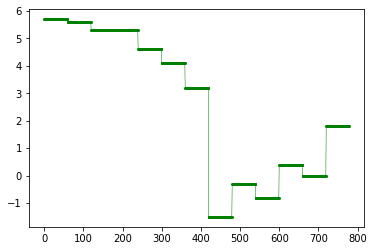

In [1867]:
plt.plot(Tdp,'go-', linewidth=0.5, markersize=2)


plt.show()

## Nova seção

In [1868]:
a = abs(basePVT['e_Ts']).mean()

In [1869]:
b = abs(basePVT['e_Tt']).mean()

In [1870]:
a = str(a)
b = str(b)
a = a.replace('.',',')
b = b.replace('.',',')

# Nova seção

In [1779]:
a

'11,117827720052912'

In [1780]:
b

'20,710348510964916'